# Survival phenotype Chunk single cell analysis tutorial

In this tutorial, you can learn how to perform a single-cell Chunk analysis to identify prognosis-associated LRI.

As input, you need single-cell transcriptomic data, bulk expression matrices, and survival phenotypic annotations of bulk samples (survival time and survival state of each bulk sample).

As an example, we will use a set of lung adenocarcinom scRNA-seq data and a set of bulk RNA-seq data from a lung adenocarcinom patient cohort, along with their corresponding phenotypic labels, to perform Chunk analysis and identify poor prognosis-associated CCI.

See our manuscript for more details.

## import

In [1]:
import Chunk
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Loading Bulk data and Data processing

First, we load the bulk data from lung adenocarcinom and its corresponding clinical meta-data (including the survival time and survival state of each bulk sample). Note that the expression matrix we load should have samples as columns and genes as rows, while the clinical meta-file should have samples as rows and clinical information as columns.

In [2]:
expr_df = pd.read_csv('data/LUAD.csv', header=0, index_col=0).T 
clin_df = pd.read_csv('data/LUAD_survival.csv', index_col=0, header=0)

Next, we use Chunk to filter the bulk expression matrix: We select genes that express ligands and receptors, and filter out genes with an average expression level below 1 (log2(tpm+1)). Chunk uses the ligand-receptor database from SingleCellSignalR by default.

In [3]:
lr_expr_pairs, lr_expr_df = Chunk.filter_Bulkdata(expr_df,threshold=1)

**Note:** Of course, you can provide Chunk with a customized ligand-receptor database according to your needs, and choose whether to filter out lowly expressed genes. The ligand-receptor database you provide should be in CSV format and must have two columns named "ligand" and "receptor".

In [ ]:
lr_expr_pairs, lr_expr_df = Chunk.filter_Bulkdata(bulk_data = expr_df,lr_db_path = "Human-2020-Cabello-Aguilar-LR-pairs.csv")

Next, we process the meta data to obtain the phenotypic constraints and other relevant information required for Chunk analysis. Here, S is the phenotypic constraint used by Chunk to identify LRI, time and event are the phenotypic constraint used to identify CCI. 


**Note:** The clin_df must include the columns **'OS.time'**(survival time) and **'OS'**(survival state), and the sample order should match that of the bulk expression matrix. interest=1 indicates focusing on poorer prognoses, while interest=0 indicates the opposite.

In [4]:
S = Chunk.getProgConstraint(clin_df,interest =1)
time, event = Chunk.getCoxelement(clin_df)

In addition, Chunk.getProgConstraint function would converts survival - related phenotypes into a linearized score using the complete rank method and adds it to clin_df for association analysis.

In [5]:
clin_df

OS.time  OS      _PATIENT  completerank
sample                                                   
TCGA-55-A57B-01A    546.0   0  TCGA-55-A57B      0.338640
TCGA-38-4627-11A   1147.0   1  TCGA-38-4627      0.572177
TCGA-55-7903-01A    567.0   0  TCGA-55-7903      0.334830
TCGA-62-A470-01A   1194.0   1  TCGA-62-A470      0.557013
TCGA-50-5939-11A    460.0   1  TCGA-50-5939      0.825592
...                   ...  ..           ...           ...
TCGA-64-1678-01A   1189.0   0  TCGA-64-1678      0.218938
TCGA-44-3398-01A   1163.0   0  TCGA-44-3398      0.223604
TCGA-97-7554-01A    775.0   0  TCGA-97-7554      0.292128
TCGA-97-A4M0-01A    652.0   0  TCGA-97-A4M0      0.319964
TCGA-49-6743-01A   1621.0   0  TCGA-49-6743      0.139034

[576 rows x 4 columns]

## Building Communication Potential Matrix

In [6]:
comm_matrix2 = Chunk.build_communication_matrix(lr_expr_pairs, lr_expr_df)

## identify phenotype-associated LRIs

Before performing phenotype-associated LRI analysis using Chunk, we need to estimate the number of potential biological patterns in this bulk cohort using the elbow method. Users can control the number of identified potential biological patterns by adjusting the elbow point (eii_tol). Chunk defaults to an eii_tol value of 0.05.

In [7]:
optimal_K = Chunk.select_k_nmf(
    comm_matrix2.T.values.astype(float), S, k_max=20, repeat_times=5, verbose=True, eii_tol = 0.05,
    use_semi_supervised=True,
    semi_supervised_params={"alpha": 0.01, "beta": 0.01, "rho": 0.75}
)

K=2, Reconstruction Error=772135.5000
K=3, Reconstruction Error=692147.3750
K=4, Reconstruction Error=631871.5500
K=4, eii=0.4297
K=5, Reconstruction Error=577524.0000
K=5, eii=0.2793
K=6, Reconstruction Error=535513.8125
K=6, eii=0.1775
K=7, Reconstruction Error=506319.5438
K=7, eii=0.1098
K=8, Reconstruction Error=481486.4188
K=8, eii=0.0854
K=9, Reconstruction Error=459505.6375
K=9, eii=0.0703
K=10, Reconstruction Error=441621.7687
K=10, eii=0.0541
K=11, Reconstruction Error=424289.0438
K=11, eii=0.0498


Then, we execute Chunk to perform phenotype-guided decomposition of the cell communication potential matrix to identify specific communication patterns.

In [8]:
W, H, loss_history = Chunk.LRcommMining(X = comm_matrix2.T.values.astype(float), S=S, n_components=optimal_K, alpha=0.01, beta=0.01, rho=0.75, maxiter=8000, lr=0.001)

Iteration 0/8000, Loss: 443325.5312
Iteration 50/8000, Loss: 442563.4375
Iteration 100/8000, Loss: 441931.9062
Iteration 150/8000, Loss: 441381.8750
Iteration 200/8000, Loss: 440884.9062
Iteration 250/8000, Loss: 440432.9375
Iteration 300/8000, Loss: 440018.9375
Iteration 350/8000, Loss: 439634.2812
Iteration 400/8000, Loss: 439275.8438
Iteration 450/8000, Loss: 438943.7812
Iteration 500/8000, Loss: 438634.3750
Iteration 550/8000, Loss: 438350.1250
Iteration 600/8000, Loss: 438085.9375
Iteration 650/8000, Loss: 437838.0312
Iteration 700/8000, Loss: 437605.1250
Iteration 750/8000, Loss: 437389.5625
Iteration 800/8000, Loss: 437185.4062
Iteration 850/8000, Loss: 436993.0938
Iteration 900/8000, Loss: 436815.6250
Iteration 950/8000, Loss: 436649.0312
Iteration 1000/8000, Loss: 436494.1562
Iteration 1050/8000, Loss: 436350.5938
Iteration 1100/8000, Loss: 436219.7188
Iteration 1150/8000, Loss: 436102.2812
Iteration 1200/8000, Loss: 435997.0938
Iteration 1250/8000, Loss: 435901.9688
Iteration

Using the association analysis provided by Chunk, we can evaluate which patterns are more relevant to the phenotypes of interest. 

Chunk considers a positive correlation to be more related to phenotypes with higher numerical values (higher completerank scores mean patients with poorer prognosis).

In [9]:
phenotype_types = {
    "completerank": "continuous",#The column name of the phenotype in sorted_clin_df: The type of the phenotype ("binary","continuous","ordinal")
}

result = Chunk.Singleassociationanalysis(W, clin_df, phenotype_types)

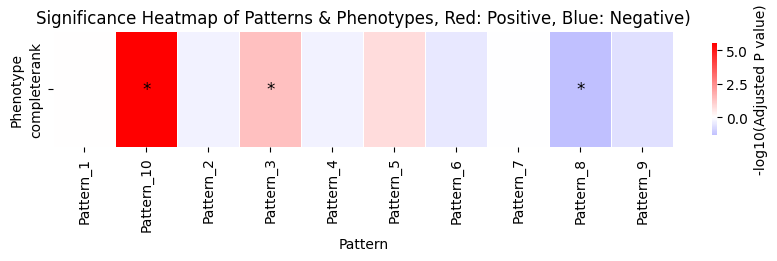

In [10]:
Chunk.plot_significance_heatmap(result, alpha = 0.05)

Patterns 3 and 10 are significantly more associated with the poorer prognosis. To further investigate, we extract the top LRIs (Ligand-Receptor Interactions) from these patterns and visualize them.

In [11]:
res = Chunk.getLRcomm(W,H,comm_matrix2,patterns = [3,10], lr_expr_pairs = lr_expr_pairs, zscore_threshold = 2)

In [12]:
Chunk.plot_sankey(res, title="Ligand-Receptor Interaction", width=800, height=1200,thickness=80,font_size=20)

## Loading scRNA-seq data and Data processing

Guided by the phenotypic information, Chunk will project these LRIs into single-cell or spatial transcriptomic contexts to uncover how they manifest as specific cell–cell communication events within the tissue context.

In [13]:
adata = sc.read_h5ad("data/LUAD_sc.h5ad")

To perform single-cell analysis with Chunk, we need to calculate the cell adjacency matrix to constrain the analysis. Scanpy provides the **sc.pp.neighbors** function to compute the similarity matrix stored in **adata.obsp['connectivities']**. After computing **adata.obsp['connectivities']**, we can use Chunk to convert it into a cell adjacency matrix.

In [14]:
cell_adj = Chunk.similarity2adjacent(adata, key='connectivities')

Filtering the genes in the scRNA-seq data based on the phenotype-associated Ligand-Receptor genes identified by Chunk, we obtain the ligand-receptor expression vectors for each cell. We then calculate the pairwise correlation with the ligand-receptor expression vectors of the bulk samples.

In [15]:
sc_lr_expr_df, sc_lr_expr_pairs = Chunk.filter_scRNAdata(res, adata, label = 'CellName')
print("Expression matrix shape:", sc_lr_expr_df.shape)
X = Chunk.calculate_correlation_matrix(lr_expr_df, sc_lr_expr_df)

Expression matrix shape: (84, 89887)
|**************************************************|
Performing quality-check for the correlations
The five-number summary of correlations:
Min: -0.16806752231643537
25th Percentile: 0.4638839900776611
Median: 0.5477133827854774
75th Percentile: 0.6199589512327321
Max: 0.9258869577744384
|**************************************************|


## Identify phenotype-associated CCI active cells

Chunk will select different regression models for optimization based on the different phenotype type (method = 'binary' or 'linear' or 'cox' or 'ordinal').

In [16]:
CCcomm = Chunk.CCcommInfer(method="cox", X = X,time = time,event = event, alpha=0, lambda_=0.1, Omega=cell_adj, learning_rate=0.001, n_epochs=1000)

Epoch [100/1000], Loss: 5.4507
Epoch [200/1000], Loss: 5.4269
Epoch [300/1000], Loss: 5.4157
Epoch [400/1000], Loss: 5.4097
Epoch [500/1000], Loss: 5.4062
Epoch [600/1000], Loss: 5.4038
Epoch [700/1000], Loss: 5.4020
Epoch [800/1000], Loss: 5.4004
Epoch [900/1000], Loss: 5.3991
Epoch [1000/1000], Loss: 5.3979


Based on the optimization results from Chunk, we extract the subset of cells with the highest influence weights as phenotype-associated CCI active cells for subsequent analysis (Chunk defaults to the top 40% positive weights).

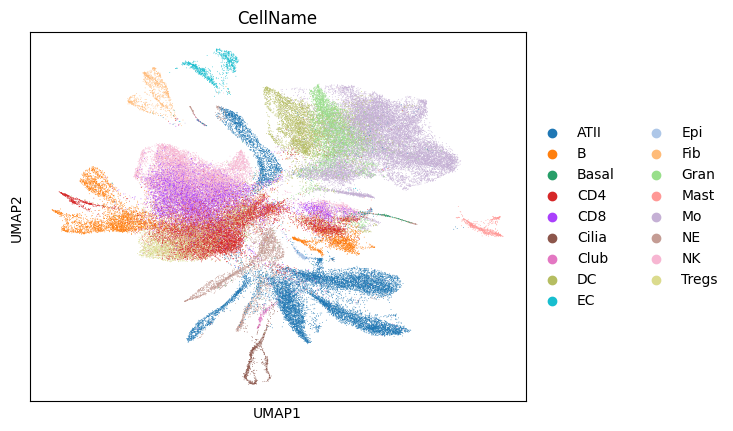

In [17]:
sc.pl.umap(adata, color='CellName')

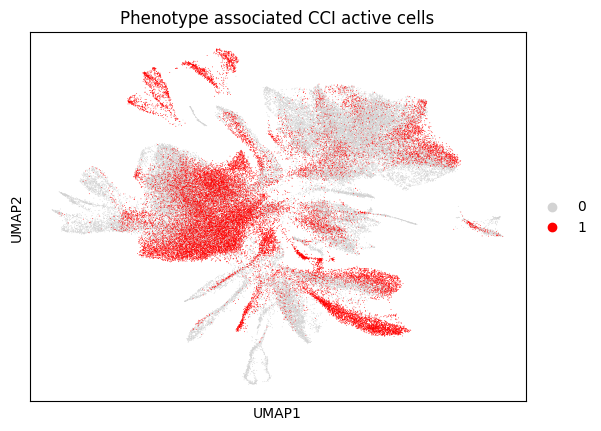

In [18]:
Chunk.getPosipotentialCCI(adata, CCcomm.model, threshold_percent=60) #The 40%(100-60) of cells with the strongest positive correlation with COVID-19.
#In some cases, Chunk also provides a method to extract phenotype-associated CCI active cells with negative correlations to phenotype
#Chunk.getNegapotentialCCI(adata, CCcomm.model, threshold_percent=40) #The 40% of cells with the strongest negative correlation with COVID-19.

## Identify phenotype-associated CCI

After running the Chunk.getPosipotentialCCI (or getNegapotentialCCI) method, the adata.obs will gain a new attribute called 'phe_cell' ('negative_phe_cell' for negative correlations). Cells marked with a value of 1 are identified as phenotype-associated CCI active cells.

Chunk can visualize the cells with the top highly expressed ligand-receptor genes among these active cells.

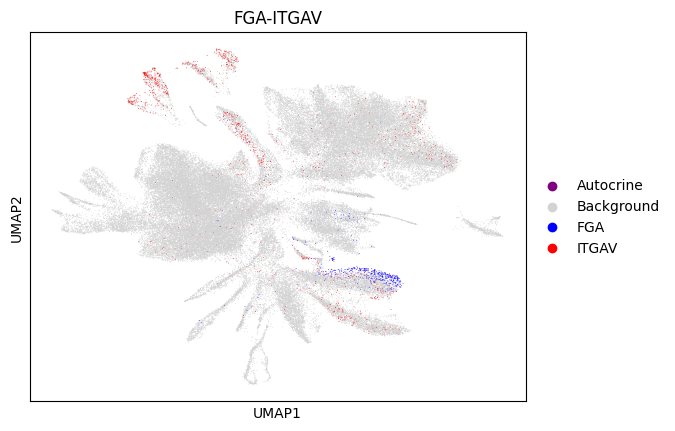

In [19]:
Chunk.getCCcomm(adata, 'FGA', 'ITGAV', L_threshold=5, R_threshold=5, marked_col='phe_cell')#top 5% high expression

Chunk provides a method for detecting phenotype-associated CCI events in single-cell data, similar to the approaches used by CellPhoneDB and CellChat.

First, we extract the phenotype-associated CCI active cells. You can customize the cell types (interestcell) for your study based on the results from running Chunk.getPosipotentialCCI (or getNegapotentialCCI) or according to your specific research question.



In [20]:
adata1 = adata[adata.obs['phe_cell'] == '1', :].copy()
adata1 = adata1[~adata1.obs['CellName'].isna(),:]
Allcell = np.unique(adata1.obs['CellName'].values).tolist()
interestcell = ['ATII', 'CD4', 'CD8', 'EC', 'Epi', 'Fib', 'Mast', 'Mo', 'NE', 'NK', 'Tregs']

In [21]:
pvalues, means, significant_means = Chunk.CCIdetect(
        adata=adata1,
        celltype_key='CellName',
        interactions=res,
        iterations=1000,
        senders=interestcell,
        receivers=interestcell
    )

Running randomization analysis: 100%|██████████████████████████████████████████████| 1000/1000 [02:37<00:00,  6.36it/s]


**visualizing the results from Chunk.CCIdetect**

We visualize the number of phenotype-associated CCIs occurring between different cell types, which can intuitively show which cells are the main participants.

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 357.3477350813719
Plotting legends..
Estimated legend width: 14.465277777777779 mm


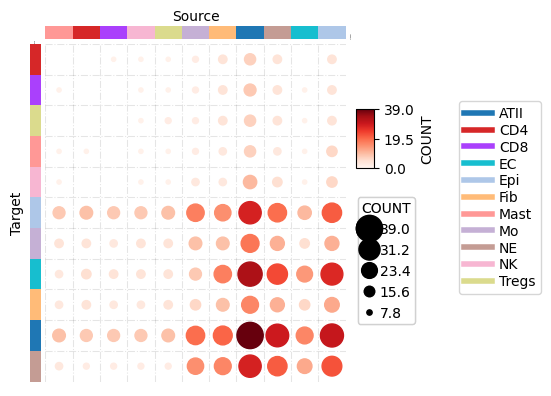

In [22]:
interaction_edges = Chunk.extract_interaction_edges(pvalues, alpha=0.05)
fig, ax = plt.subplots(figsize=(4,4)) 
Chunk.cci_heatmap(adata1[adata1.obs['CellName'].isin(interestcell),:],interaction_edges,celltype_key='CellName',
                   fontsize=10,target_cells = interestcell, source_cells = interestcell,
          ax=ax,legend_kws={'fontsize':10,'bbox_to_anchor':(5, -0.5),'loc':'center left',})
plt.show()

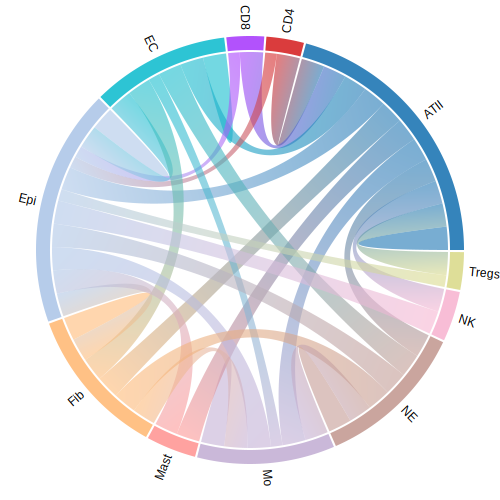

In [23]:
fig=Chunk.cci_chord(adata1,interaction_edges,celltype_key='CellName',
          count_min=5,fontsize=12,padding=50,radius=200,save=None,) #count_min: Only shows CCI mediated by more than five specific ligand-receptor types
fig.show()

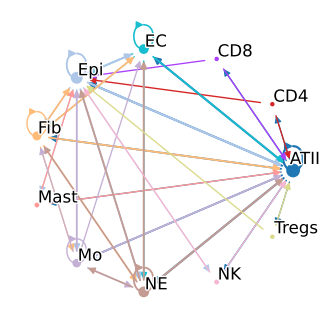

In [24]:
fig, ax = plt.subplots(figsize=(4,4)) 
Chunk.cci_network(adata1,interaction_edges,celltype_key='CellName',
             counts_min=5,
            nodesize_scale=5,
                  ax=ax)
plt.show()

We can visualize exactly which phenotypic-related CCI activities occur among specific cell types

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 57.1881942635084
Plotting legends..
Estimated legend width: 16.758333333333333 mm


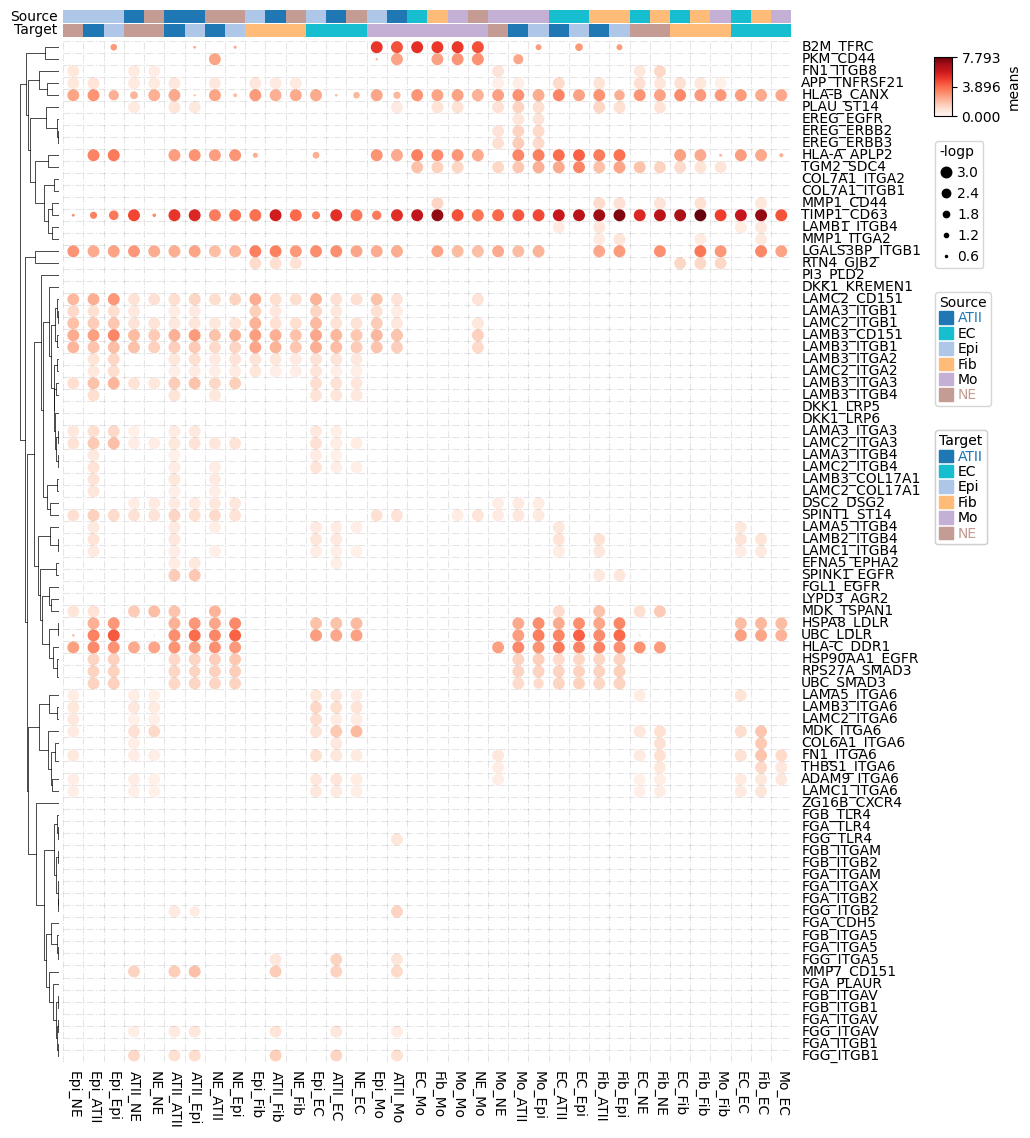

In [25]:
source_cells=['ATII', 'EC', 'Epi', 'Fib', 'Mo', 'NE']
target_cells=['ATII', 'EC', 'Epi', 'Fib', 'Mo', 'NE']
Chunk.cci_interacting_heatmap(adata=adata1,
                            celltype_key='CellName',
                            means=means, 
                            pvalues=pvalues, 
                            source_cells=source_cells,
                            target_cells=target_cells,
                            min_means=1,
                            nodecolor_dict=None,
                            ax=None,
                            figsize=(10,12),
                            fontsize=10,)

plt.show()

Visualize the CCI network of phenotype-associated CCIs for specific cell types.

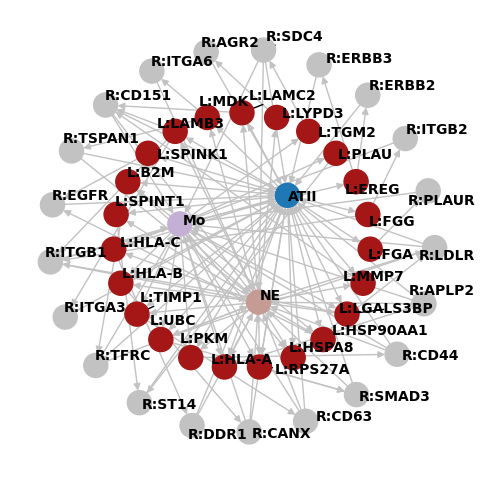

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
Chunk.cci_interacting_network(adata=adata1,
                         celltype_key='CellName',
                            means=means,
                            source_cells=['ATII','Mo', 'NE'],
                            target_cells=['ATII','Mo', 'NE'],
                            means_min=1,
                             means_sum_min=1,        
                            fontsize=10,
                            ax=ax)
plt.show()

# means_sum_min:
# If the sum of interaction strengths of a given ligand-receptor pair 
# across all source-target cell pairs is greater than this threshold, 
# then this ligand-receptor pair is considered for inclusion in the network.
# (i.e., filter out globally weak ligand-receptor pairs)

# means_min:
# For a ligand-receptor pair that passes the global threshold (means_min),
# only those specific cell-cell interactions (CCI) where the interaction 
# strength exceeds this threshold will be shown in the network.
# (i.e., filter out weak CCIs even if the ligand-receptor pair is overall strong)